In [344]:
import jax
from jax import numpy as jnp
import mujoco
from mujoco import mjx
import mediapy as media
from ik import IKSolver
from controller import PID
from trajectory import Trajectory

In [345]:
xml = """
<mujoco model="3dof_robot_arm">
    <compiler angle="radian" coordinate="local"/>
    <option gravity="0 0 -9.81" integrator="RK4" timestep="0.001"/>

    <worldbody>
            <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
        <geom name="floor" pos="0 0 -0.1" size="1 1 0.1" type="plane" rgba="0.8 0.9 0.8 1"/>
         
        <!-- Base of the robot arm -->
        <body name="base" pos="0 0 0">
            <!-- Joint 1: Base rotation -->
            <joint name="joint1" type="hinge" axis="0 0 1" limited="true" range="-180 180"/>
            <!-- Link 1 -->
            <geom name="link1_geom" type="capsule" fromto="0 0 0 0 0 0.5" size="0.05" mass="1"/>
            <!-- Link 2 -->
            <body name="link2" pos="0 0 0.5">
                <!-- Joint 2: Shoulder pitch (up/down) -->
                <joint name="joint2" type="hinge" axis="0 1 0" limited="true" range="-90 90"/>
                <geom name="link2_geom" type="capsule" fromto="0 0 0 0 0 0.5" size="0.05" mass="0.8"/>
                <!-- Link 3 -->
                <body name="link3" pos="0 0 0.5">
                    <!-- Joint 3: Elbow pitch (up/down) -->
                    <joint name="joint3" type="hinge" axis="0 1 0" limited="true" range="-90 90"/>
                    <geom name="link3_geom" type="capsule" fromto="0 0 0 0 0 0.5" size="0.05" mass="0.6"/>
                    <!-- End-effector -->
                    <body name="end_effector" pos="0 0 0.5">
                        <geom type="sphere" size="0.05" rgba="1 0 0 1" mass="0.2"/>
                        <site name="end_eff" pos="0 0 0" size="0.01" rgba="1 0 0 1"/>
                    </body>
                </body>
            </body>
        </body>
<body name="target" pos="0.3 0.3 1">
            <geom name="target" type="sphere" size="0.02" rgba="0 0 1 0.5"/>
        </body>
    </worldbody>

    <actuator>
        <position joint="joint1" ctrlrange="-3.14 3.14" kp="7" kv="0.9" ctrllimited="true" />
        <position joint="joint2" ctrlrange="-3.14 3.14" kp="12" kv="1.3" ctrllimited="true" />
        <position joint="joint3" ctrlrange="-3.14 3.14" kp="7" kv="0.9" ctrllimited="true" />
    </actuator>
   <sensor>
    <jointpos name="joint1_pos" joint="joint1"/>
    <jointpos name="joint2_pos" joint="joint2"/>
    <jointpos name="joint3_pos" joint="joint3"/>
    <framepos name="end_effector_pos" objtype="body" objname="end_effector"/>
</sensor> 
</mujoco>
"""

In [346]:

mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

In [347]:
def gravity_torque(q: jnp.ndarray):
    # Parameters
    g = 9.81
    L2 = 0.5
    L3 = 0.5
    m2 = 0.8
    m3 = 0.6

    q1, q2, q3 = q

    term_m2 = m2 * (L2 / 2) * jnp.cos(q1 + q2)
    term_m3 = m3 * (L2 * jnp.cos(q1 + q2) + (L3 / 2) * jnp.cos(q1 + q2 + q3))
    G2 = g * (term_m2 + term_m3)
    return G2

In [348]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(mj_model, camera)
camera.distance = 2
target = jnp.array([0.3, 0.3, 1], dtype="float64")


q0 = jnp.array([0, -jnp.pi/2, 0])

solver = IKSolver(desired_pose=target, initial_q=q0, learning_rate=0.001, joint_lengths=jnp.array([]))
q = jnp.array(solver.iterative_solver(q0=q0))
q

/var/folders/fq/ngnyvd554hvcllzzslff76wr0000gn/T/ipykernel_2591/2309861408.py:4: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  target = jnp.array([0.3, 0.3, 1], dtype="float64")


Array([ -2.344924, -14.130485,  26.865032], dtype=float32)

In [349]:
q1_controller = PID(0, 0.4, 2)
q2_controller = PID(0, -0.1, 1)
q3_controller = PID(0, 0.4, 2)

In [350]:
def transform_joint_angles(angle):
  return jnp.where(
        (angle > -3.14) & (angle < 3.14),
        angle,
        ((angle + jnp.pi) % (2 * jnp.pi)) - jnp.pi
    )

In [351]:
vmap_transform = jax.vmap(transform_joint_angles) 
q_res = vmap_transform(q)
q_res

Array([-2.344924 , -1.5641134,  1.7322896], dtype=float32)

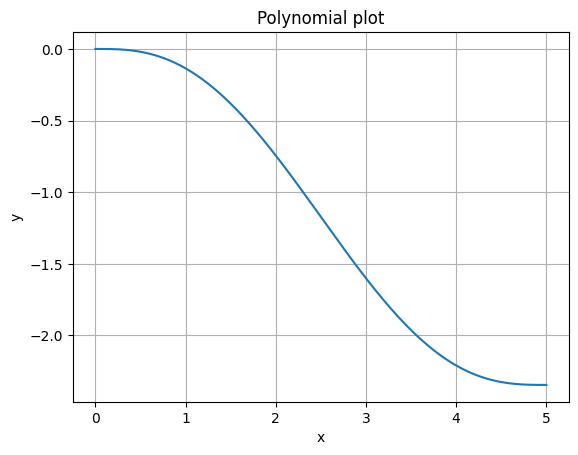

In [352]:
import matplotlib.pyplot as plt
q1_constants = jnp.array([
    q0[0],
    0,
    0,
    q_res[0],
    0,
    0
])
q1_trajectory = Trajectory(constants=q1_constants, horizon=5)
q1_polynomial = q1_trajectory.generate()

q1_values = jnp.polyval(jnp.flip(q1_polynomial),jnp.linspace(0, 5, 5000))

q2_constants = jnp.array([
    q0[1],
    0,
    0,
    q_res[1],
    0,
    0
])
q2_trajectory = Trajectory(constants=q2_constants, horizon=5)
q2_polynomial = q2_trajectory.generate()

q2_values = jnp.polyval(jnp.flip(q2_polynomial),jnp.linspace(0, 5, 5000))

q3_constants = jnp.array([
    q0[2],
    0,
    0,
    q_res[2],
    0,
    0
])
q3_trajectory = Trajectory(constants=q3_constants, horizon=5)
q3_polynomial = q3_trajectory.generate()
q3_values = jnp.polyval(jnp.flip(q3_polynomial),jnp.linspace(0, 5, 5000))


xs = jnp.linspace(0, 5, 5000)
ys = jnp.polyval(jnp.flip(q1_polynomial), xs)
plt.plot(xs, ys)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Polynomial plot")
plt.grid(True)
plt.show()


In [354]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 7  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
print(mj_model.nv)
mj_data.qpos = q0
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, camera)
ctrls = [] 
differences = []
while mj_data.time < duration:

  """ current_q1 = mj_data.qpos[0]
  current_q2 = mj_data.qpos[1]
  current_q3 = mj_data.qpos[2]

  q1 = q1_controller.control(current=current_q1, reference=q[0], time_step=mj_data.time)
  q2 = q2_controller.control(current=current_q2, reference=q[1], time_step=mj_data.time)
  q3 = q3_controller.control(current=current_q3, reference=q[2], time_step=mj_data.time)
  
  print(current_q2)
  ctrls.append(q2)

  mj_data.ctrl = jnp.array([q1, q2 + gravity_torque(mj_data.qpos), 0]) """

  index = int(jnp.floor(mj_data.time * 1000))
  differences.append(q_res[2] - mj_data.qpos[2])
  control = jnp.array([q1_values.at[index].get(), q2_values.at[index].get(), q3_values.at[index].get()])
  mj_data.ctrl = control 

  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option, camera=camera)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

3


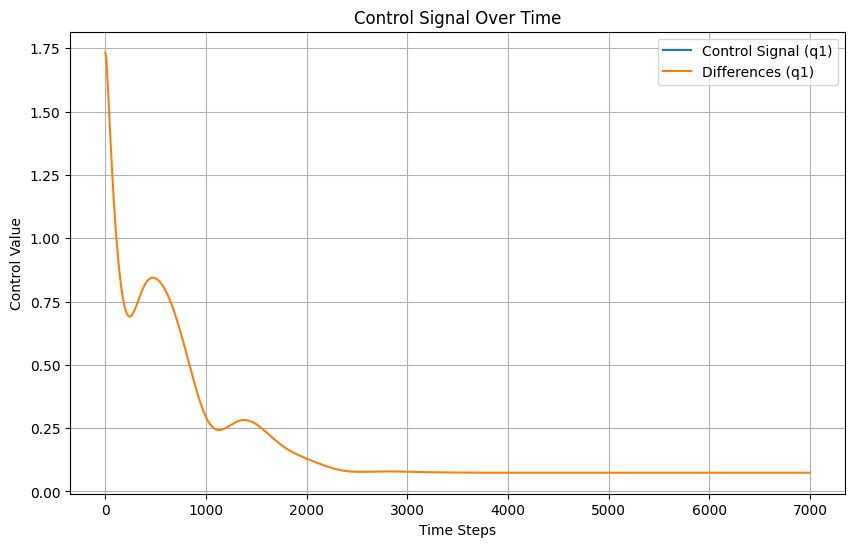

In [305]:
import matplotlib.pyplot as plt

# Plot the control values
plt.figure(figsize=(10, 6))
plt.plot(ctrls, label='Control Signal (q1)')
plt.plot(differences, label='Differences (q1)')
plt.xlabel('Time Steps')
plt.ylabel('Control Value')
plt.title('Control Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()